<a href="https://colab.research.google.com/github/ericyoc/google_co-lab_haarcascade_capture_poc/blob/main/google_co_lab_haarcascade_capture_save_image_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import dependencies
import cv2
import numpy as np
from IPython.display import Image, Javascript, display
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import io
import PIL

In [ ]:
# Function to convert JavaScript object into an OpenCV image
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

In [ ]:
# Function to convert OpenCV Rectangle bounding box image into base64 byte string
def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

In [ ]:
# Function to start the video stream and capture a photo
def start_video_and_capture(quality=0.8, detection_type='face'):
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var captureButton;
        var capturedPhoto = null;
        var imgElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {
           stream.getVideoTracks()[0].stop();
           video.remove();
           div.remove();
           video = null;
           div = null;
           stream = null;
           captureCanvas = null;
           captureButton = null;
           imgElement = null;
        }

        function onAnimationFrame() {
            if (!shutdown) {
                window.requestAnimationFrame(onAnimationFrame);
            }
            if (pendingResolve) {
                var result = "";
                if (!shutdown) {
                    captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                    result = captureCanvas.toDataURL('image/jpeg', 0.8)
                }
                var lp = pendingResolve;
                pendingResolve = null;
                lp(result);
            }
        }

        async function createDom() {
            if (div !== null) {
                return stream;
            }

            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);

            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };
            stream = await navigator.mediaDevices.getUserMedia(
                {video: { facingMode: "environment"}});
            div.appendChild(video);

            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => { shutdown = true; };
            div.appendChild(imgElement);

            captureButton = document.createElement('button');
            captureButton.textContent = 'Capture Photo';
            captureButton.addEventListener('click', () => {
                capturedPhoto = captureCanvas.toDataURL('image/jpeg', 0.8);
            });
            div.appendChild(captureButton);

            video.srcObject = stream;
            await video.play();

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = 640; //video.videoWidth;
            captureCanvas.height = 480; //video.videoHeight;
            window.requestAnimationFrame(onAnimationFrame);

            return stream;
        }
        async function stream_frame(imgData) {
            if (shutdown) {
                removeDom();
                shutdown = false;
                return '';
            }

            var preCreate = Date.now();
            stream = await createDom();

            var preShow = Date.now();
            if (imgData != "") {
                var videoRect = video.getClientRects()[0];
                imgElement.style.top = videoRect.top + "px";
                imgElement.style.left = videoRect.left + "px";
                imgElement.style.width = videoRect.width + "px";
                imgElement.style.height = videoRect.height + "px";
                imgElement.src = imgData;
            }

            var preCapture = Date.now();
            var result = await new Promise(function(resolve, reject) {
                pendingResolve = resolve;
            });
            shutdown = false;

            return {'create': preShow - preCreate,
                    'show': preCapture - preShow,
                    'capture': Date.now() - preCapture,
                    'img': result,
                    'photo': capturedPhoto};
        }
    ''')

    display(js)

    # Load the appropriate Haar Cascade classifier based on the detection type
    cascade_file = None
    label_text = None
    if detection_type == 'face':
        cascade_file = cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        label_text = 'Face'
        filename = 'captured_face.jpg'
    elif detection_type == 'smile':
        cascade_file = cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_smile.xml')
        label_text = 'Smile'
        filename = 'captured_smile.jpg'
    elif detection_type == 'eye':
        cascade_file = cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_eye.xml')
        label_text = 'Eye'
        filename = 'captured_eye.jpg'

    if cascade_file is None or label_text is None:
        print(f"Invalid detection type: {detection_type}")
        return

    cascade = cv2.CascadeClassifier()
    try:
        cascade.load(cascade_file)
    except cv2.error as e:
        print(f"Error loading cascade classifier: {e}")
        return

    # Initialize bounding box to empty
    bbox = ''

    while True:
        js_reply = eval_js('stream_frame("{}")'.format(bbox))
        if not js_reply:
            break

        # Convert JavaScript response to OpenCV Image
        img = js_to_image(js_reply["img"])

        # Convert the image to grayscale for detection
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Get region coordinates based on the detection type
        if detection_type == 'smile':
            regions = cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=40, minSize=(30, 30))
        else:
            regions = cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Draw bounding boxes on the image
        for (x, y, w, h) in regions:
            # Optimize for a tighter bounding box around the region
            x_max = x + w + max(0, int(0.2 * w))
            y_max = y + h + max(0, int(0.2 * h))
            x_min = x - max(0, int(0.1 * w))
            y_min = y - max(0, int(0.1 * h))
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(img, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        # Create a transparent overlay for the bounding box
        bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

        # Draw bounding boxes on the overlay
        for (x, y, w, h) in regions:
            x_max = x + w + max(0, int(0.2 * w))
            y_max = y + h + max(0, int(0.2 * h))
            x_min = x - max(0, int(0.1 * w))
            y_min = y - max(0, int(0.1 * h))
            bbox_array = cv2.rectangle(bbox_array, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            cv2.putText(bbox_array, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
        # Convert the overlay of bbox into bytes
        bbox_bytes = bbox_to_bytes(bbox_array)
        # Update bbox so the next frame gets the new overlay
        bbox = bbox_bytes

        # Check if a photo has been captured
        if js_reply["photo"] is not None:
            cv2.imwrite(filename, img)
            print(f'Saved photo to {filename}')
            display(Image(filename))
            break

    # Clean up OpenCV resources and remove the preview window
    cv2.destroyAllWindows()
    eval_js('removeDom()')

In [ ]:
# Main function
def main():
    print("Select detection type:")
    print("f: Face")
    print("s: Smile")
    print("e: Eye")
    detection_type = input("Enter your choice: ")

    if detection_type == 'f':
        detection_type = 'face'
    elif detection_type == 's':
        detection_type = 'smile'
    elif detection_type == 'e':
        detection_type = 'eye'
    else:
        print("Invalid detection type")
        return

    # Start the video stream and capture a photo based on the selected detection type
    start_video_and_capture(detection_type=detection_type)

Select detection type:
f: Face
s: Smile
e: Eye
Enter your choice: e


<IPython.core.display.Javascript object>

Saved photo to captured_eye.jpg


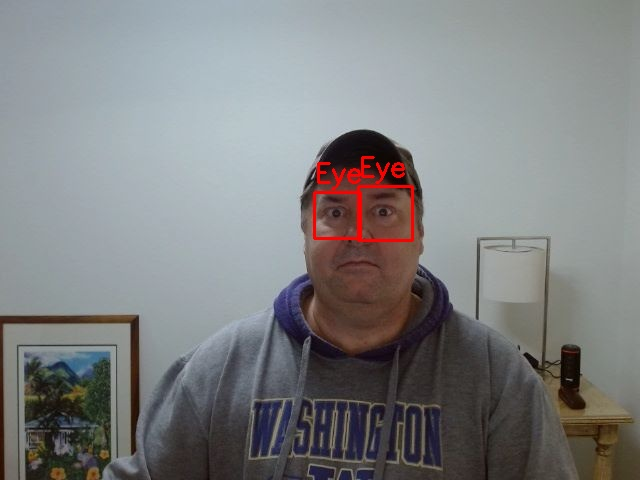

In [ ]:
if __name__ == "__main__":
    main()